In [2]:
library(ggplot2)
library(tidyverse)

Warning message:
"package 'ggplot2' was built under R version 3.5.2"Warning message:
"package 'tidyverse' was built under R version 3.5.2"-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v tibble  1.4.2     v purrr   0.2.5
v tidyr   0.8.2     v dplyr   0.7.8
v readr   1.3.1     v stringr 1.3.1
v tibble  1.4.2     v forcats 0.3.0
Warning message:
"package 'tibble' was built under R version 3.5.2"Warning message:
"package 'tidyr' was built under R version 3.5.2"Warning message:
"package 'readr' was built under R version 3.5.2"Warning message:
"package 'purrr' was built under R version 3.5.2"Warning message:
"package 'dplyr' was built under R version 3.5.2"Warning message:
"package 'stringr' was built under R version 3.5.2"Warning message:
"package 'forcats' was built under R version 3.5.2"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


In [5]:
setwd("~/Tareas universidad/7 Semestre/Data Product/Labs/Lab #2")



#Datasets
Calls <- read.csv("calls_data.csv")
GoogleA <- read.csv("ga_data.csv")
Revenue <- read.csv("revenenue.csv")

#Filtro de Fechas
Calls <- subset(Calls, as.Date.factor(Calls$process_date) <= "2018-12-24" &
                  as.Date.factor(Calls$process_date) >= "2018-12-18")

GoogleA <- subset(GoogleA, as.Date.factor(GoogleA$date) <= "2018-12-24" &
                    as.Date.factor(GoogleA$date) >= "2018-12-18")

Revenue <- subset(Revenue, as.Date.factor(Revenue$session_revenue_date) <= "2018-12-24" &
                    as.Date.factor(Revenue$session_revenue_date) >= "2018-12-18")


#                                         *****Google Analytics*****

#Sesiones Unicas
#table(GoogleA$eventLabel)
#length(GoogleA$hc_session[which(GoogleA$hc_session == "undefined")])

#Dividir por eventos el dataset
Original <- GoogleA[which(GoogleA$eventLabel =="Original"),]
Variation1 <- GoogleA[which(GoogleA$eventLabel == "Variation#1"),]
Variation2 <- GoogleA[which(GoogleA$eventLabel =="Variation#2"),]

#Eliminar los usuarios indefinidos de cada dataset
Original <- subset(Original, hc_session != "undefined")
Variation1 <- subset(Variation1, hc_session != "undefined")
Variation2 <- subset(Variation2, hc_session != "undefined")

#Verificar en donde pueden haber usuarios repetidos
Repeatedusers <- which(Variation1$hc_session %in% Variation2$hc_session)
Repeatedusers2 <- which(Original$hc_session %in% Variation1$hc_session)
Repeatedusers3 <- which(Original$hc_session %in% Variation2$hc_session)

#Identificar esos usuarios
RepeatedusersID <- as.data.frame(Variation1[Repeatedusers,3])

#Eliminar de los datasets a los usuarios repetidos
Variation1 <- subset(Variation1, !( Variation1$hc_session %in% RepeatedusersID$`Variation1[Repeatedusers, 3]`))
Variation2 <- subset(Variation2, !( Variation2$hc_session %in% RepeatedusersID$`Variation1[Repeatedusers, 3]`))

#Verificar que no hayan usuarios repetidos length deberia ser igual a las observaciones de cada dataset
#length(unique(Variation1$hc_session))
#length(unique(Variation2$hc_session))
#length(unique(Original$hc_session))


#                                          *****Revenue Data*****

#Tomar de Revenue solo los usuarios que aparecen en Google Analytics

#wv1 <- which(Variation1$hc_session %in% Revenue$session_id)
wv1 <- which(Revenue$session_id %in% Variation1$hc_session)
Var1Revenue <- Revenue[wv1,]

#wv2 <- which(Variation2$hc_session %in% Revenue$session_id)
wv2 <- which(Revenue$session_id %in% Variation2$hc_session)
Var2Revenue <- Revenue[wv2,]

#wo <- which(Original$hc_session %in% Revenue$session_id)
wo <- which(Revenue$session_id %in% Original$hc_session)
OriginalRevenue <- Revenue[wo,]

#Total de sesiones, descartar las duplicadas 
#length(unique(OriginalRevenue$session_id))
#length(unique(Var1Revenue$session_id))
#length(unique(Var2Revenue$session_id))

#Datasets a mostrar
OR <- select(OriginalRevenue, monetization_type, placement ,revenue, product, traffic_source)
V1R <-select(Var1Revenue, monetization_type, placement ,revenue, product, traffic_source)
V2R <-select(Var2Revenue, monetization_type, placement ,revenue, product, traffic_source)



#                                            *****Calls Data*****

#Juntar Calls con Google Analytics
orc <- which(Calls$session_id %in% Original$hc_session)
OriCalls <- Calls[orc,]
#OriCalls <- subset(Calls, Calls$session_id %in% Original$hc_session)

v1c <- which(Calls$session_id %in% Variation1$hc_session)
Va1Calls <- Calls[v1c,]
#Va1Calls <- subset(Calls, Calls$session_id %in% Variation1$hc_session)

v2c <- which(Calls$session_id %in% Variation2$hc_session)
Va2Calls <- Calls[v2c,]
#Va2Calls <- subset(Calls, Calls$session_id %in% Variation2$hc_session)


#                                       *****Experiment Important Data*****

EID <- as.data.frame(matrix(nrow = 0, ncol = 4))

#Unique Sessions
#"Unique Sessions"
EID <- rbind(EID, c(0, length(unique(OriginalRevenue$session_id)), 
                    length(unique(Var1Revenue$session_id)), 
                    length(unique(Var2Revenue$session_id))))

#TYP Revenue
OTYPR <-sum(OriginalRevenue$revenue[which(OriginalRevenue$placement == "TYP" |
                                          OriginalRevenue$placement == "TYP_CONNECTME")])
VR1TYPR <- sum(Var1Revenue$revenue[which(Var1Revenue$placement == "TYP" |
                                           Var1Revenue$placement == "TYP_CONNECTME")])
VR2TYPR <-sum(Var2Revenue$revenue[which(Var2Revenue$placement == "TYP" |
                                          Var2Revenue$placement == "TYP_CONNECTME")])

#"Revenue TYP"
EID <- rbind(EID, c(0, OTYPR, VR1TYPR, VR2TYPR), stringsAsFactors = FALSE)

#"RPM"
RevOR <- round(OTYPR/length(unique(OriginalRevenue$session_id))*1000, 2)
RevVar1 <- round(VR1TYPR/length(unique(Var1Revenue$session_id))*1000, 2)
RevVar2 <- round(VR2TYPR/length(unique(Var2Revenue$session_id))*1000, 2)

EID <- rbind(EID, c(0,RevOR,RevVar1,RevVar2))

#"CTR"
CTROR <- round(sum(OriginalRevenue$engagement_count[which(OriginalRevenue$placement == "TYP" |
            OriginalRevenue$placement == "TYP_CONNECTME")]
            )/sum(OriginalRevenue$engagement_count[which(OriginalRevenue$placement == "LEAD FORM")]), 2)


CTRVR1 <- round(sum(Var1Revenue$engagement_count[which(Var1Revenue$placement == "TYP")]
            )/sum(Var1Revenue$engagement_count[which(Var1Revenue$placement == "LEAD FORM")]), 2)

CTRVR2 <- round(sum(Var2Revenue$engagement_count[which(Var2Revenue$placement == "TYP" )]
           )/sum(Var2Revenue$engagement_count[which(Var2Revenue$placement == "LEAD FORM")]), 2)


EID <- rbind(EID,c(0,CTROR,CTRVR1,CTRVR2))



# Numero de llamadas por cada variacion
EID <- rbind(EID,c(0,length(unique(OriCalls$session_id)),
                   length(unique(Va1Calls$session_id)),
                   length(unique(Va2Calls$session_id))))

#"Nombres ultima Tabla"
EID[1,1] <- "Unique Sessions with Revenue"
EID[2,1] <- "Revenue TYP"
EID[3,1] <- "RPM"
EID[4,1] <- "CTR"
EID[5,1] <- "Numero de Llamadas"
colnames(EID) <- c("Metrica","Original","Variation#1","Variation#2")
#EID
 #Graficas 
h <- ggplot(Var1Revenue, aes(placement))
#h + geom_bar() 

h1 <- ggplot(Var2Revenue,aes(placement))
#h1 + geom_bar() 

h2 <- ggplot(OriginalRevenue, aes(placement))
#h2+ geom_bar() 

#Bar Chart Sessions
#Google Sessions
df1 <- data.frame(Variaciones =c("Original", "Variation #1", "Variation #2"),
                 Cantidad=c(175, 339, 786))

chart1 <- ggplot(df1, aes(x=Variaciones, y=Cantidad, fill=Variaciones))+
  geom_bar(stat="identity", color="black")+
  geom_text(aes(label=Cantidad), vjust=1.6, color="white", size=3.5)+
  scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
  theme_minimal()
#chart1  

#Revenue Sessions
df2 <- data.frame(Variaciones =c("Original", "Variation #1", "Variation #2"),
                  Cantidad=c(length(unique(OriginalRevenue$session_id)), 
                             length(unique(Var1Revenue$session_id)), 
                             length(unique(Var2Revenue$session_id))))

chart2 <- ggplot(df2, aes(x=Variaciones, y=Cantidad, fill=Variaciones))+
  geom_bar(stat="identity", color="black")+
  geom_text(aes(label=Cantidad), vjust=1.6, color="white", size=3.5)+
  scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
  theme_minimal()
#chart2

#Important Data
df3 <- as.data.frame(matrix(nrow = 3, ncol = 0))
df3 <- cbind(df3, c("Original","Variation #1","Variation #2"))
df3 <- cbind(df3, c(OTYPR, VR1TYPR, VR2TYPR))
df3 <- cbind(df3, c(RevOR,RevVar1,RevVar2))
df3 <- cbind(df3, c(CTROR,CTRVR1,CTRVR2))
df3 <- cbind(df3,c(length(unique(OriCalls$session_id)),
                 length(unique(Va1Calls$session_id)),
                 length(unique(Va2Calls$session_id))))
colnames(df3) <- c("Variation","Revenue_TYP","RPM","CTR","Numero_Llamadas")

#Revenue TYP
chart3 <- ggplot(df3, aes(x=Variation, y=Revenue_TYP, fill=Variation))+
  geom_bar(stat="identity", color="black")+
  geom_text(aes(label=Revenue_TYP), vjust=1.6, color="white", size=3.5)+
  scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
  theme_minimal()
#chart3

#RPM
chart4 <- ggplot(df3, aes(x=Variation, y=RPM, fill=Variation))+
  geom_bar(stat="identity", color="black")+
  geom_text(aes(label=RPM), vjust=1.6, color="white", size=3.5)+
  scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
  theme_minimal()
#chart4

#CTR
chart5 <- ggplot(df3, aes(x=Variation, y=CTR, fill=Variation))+
  geom_bar(stat="identity", color="black")+
  geom_text(aes(label=CTR), vjust=1.6, color="white", size=3.5)+
  scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
  theme_minimal()
#chart5

#Numero de Llamadas
chart6 <- ggplot(df3, aes(x=Variation, y=Numero_Llamadas, fill=Variation))+
  geom_bar(stat="identity", color="black")+
  geom_text(aes(label=Numero_Llamadas), vjust=1.6, color="white", size=3.5)+
  scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
  theme_minimal()
#chart6


**Google Analytics Data**

Data is from 2018-12-18 to 2018-12-24

Total Sessions: 1300

Se omitieron 2 observaciones debido a colisión entre variaciones

Se omitieron 42 observaciones debido a que en la session aparecia “undefined”

# Google Analytics Data

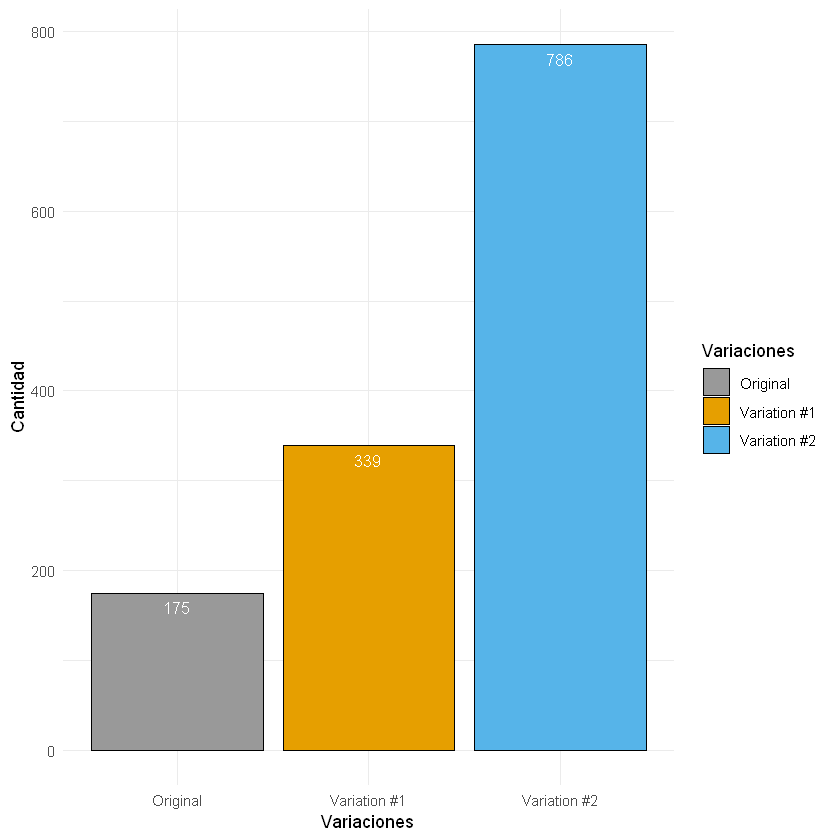

In [6]:
chart1  

# Revenue Data, Total Sessions: 762

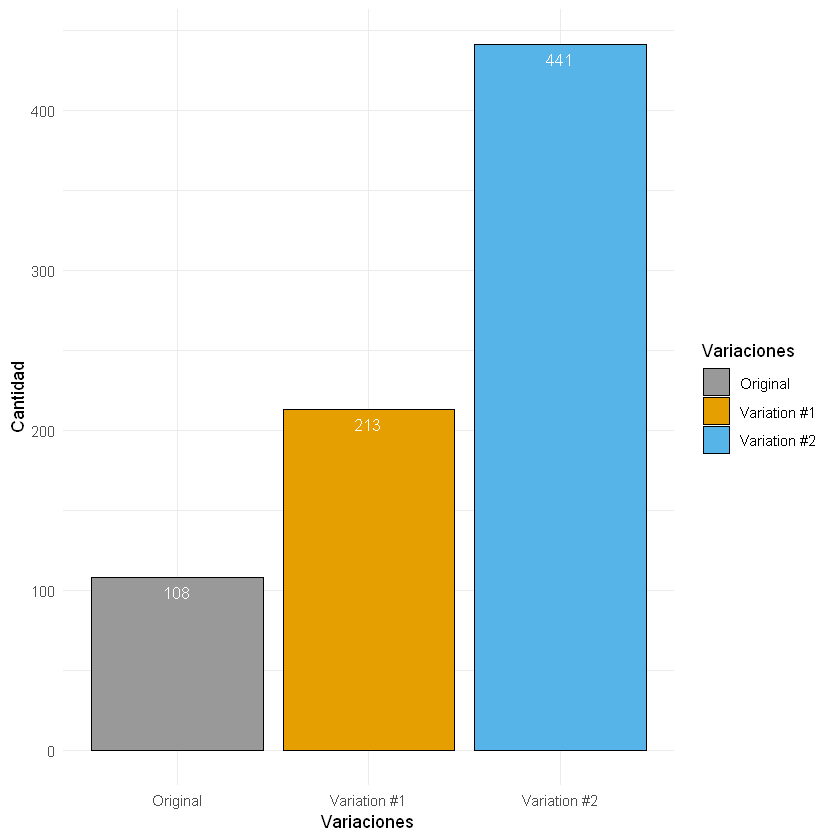

In [7]:
chart2

# Placement Variation #1

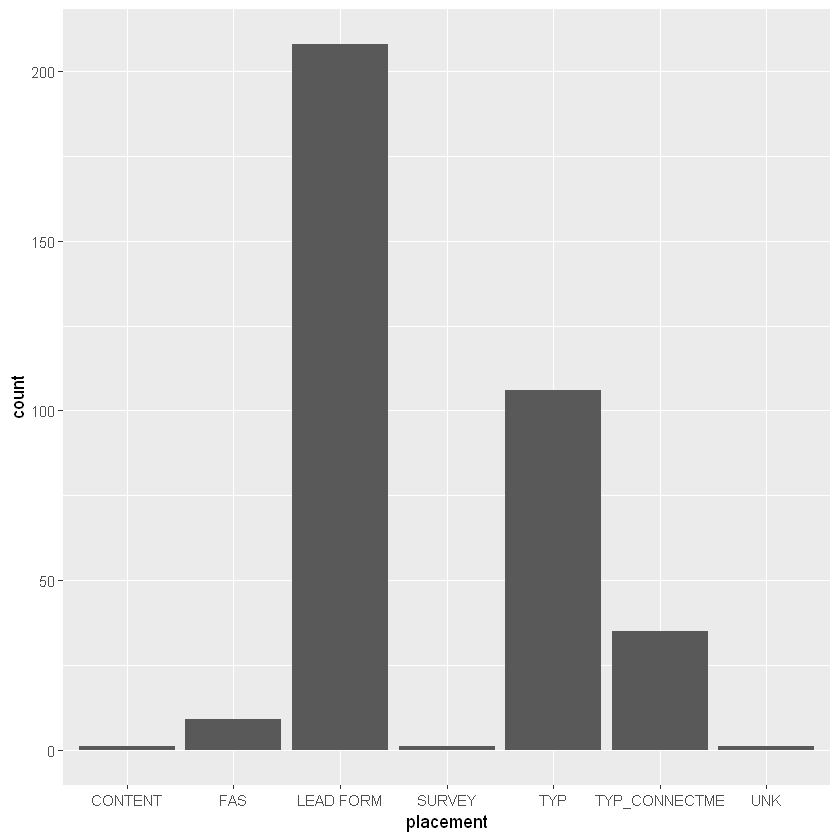

In [8]:
h + geom_bar() 

# Placement Variation #2

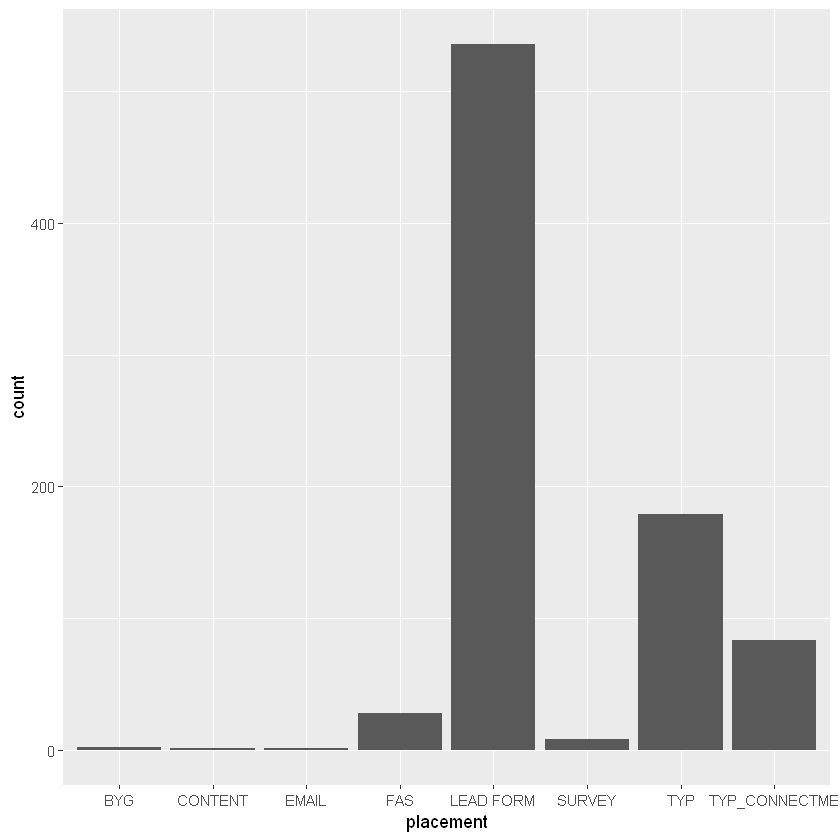

In [10]:
h1 + geom_bar() 

# Placement Original

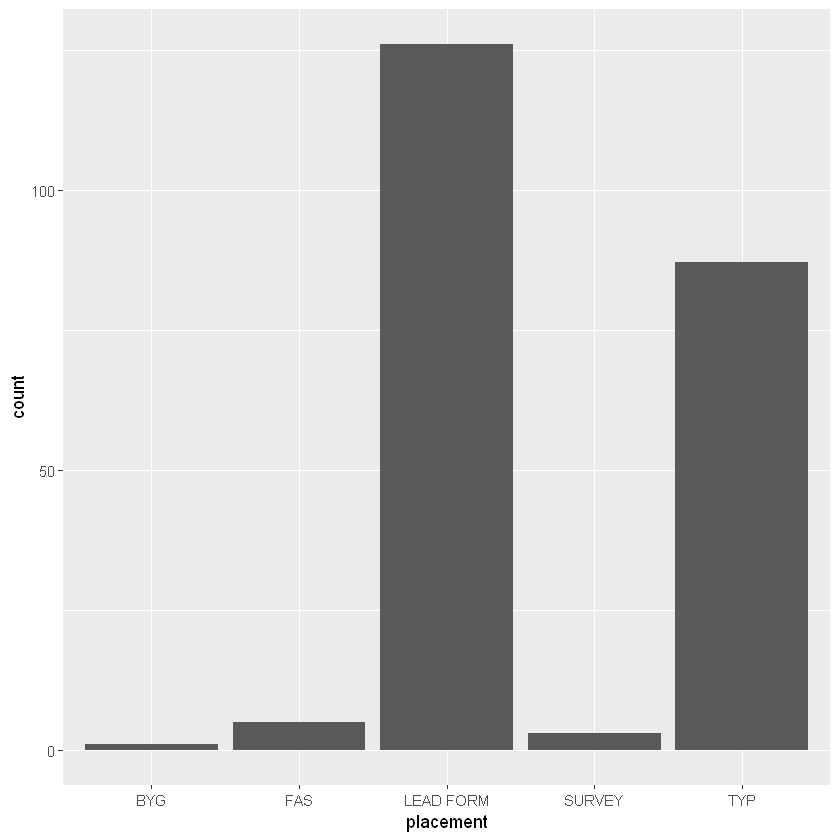

In [11]:
h2+ geom_bar() 

# Revenue TYP

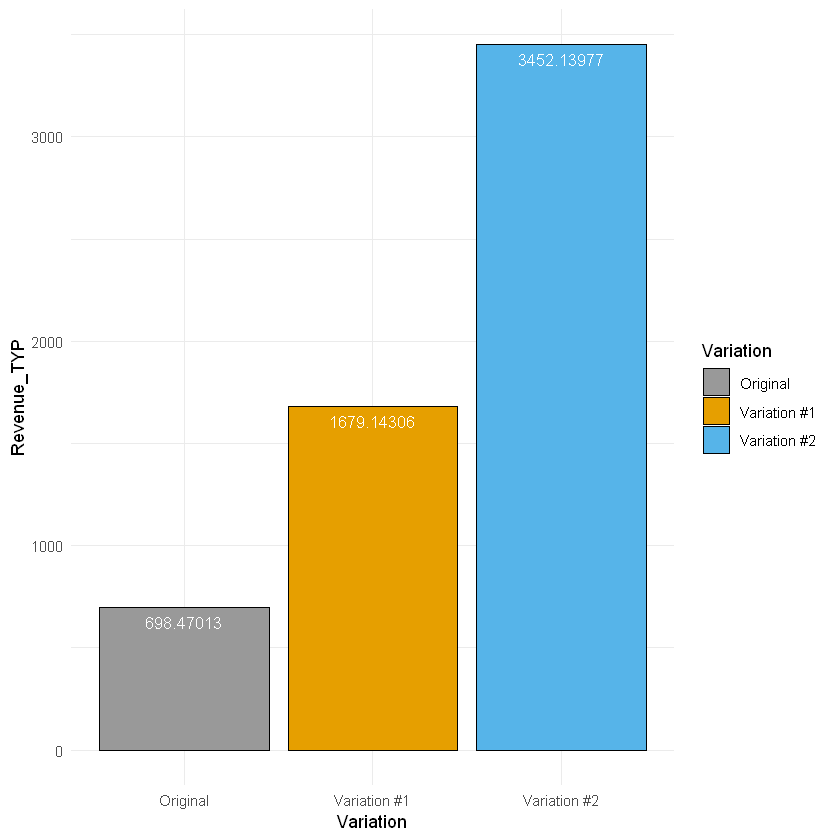

In [12]:
chart3

# RPM



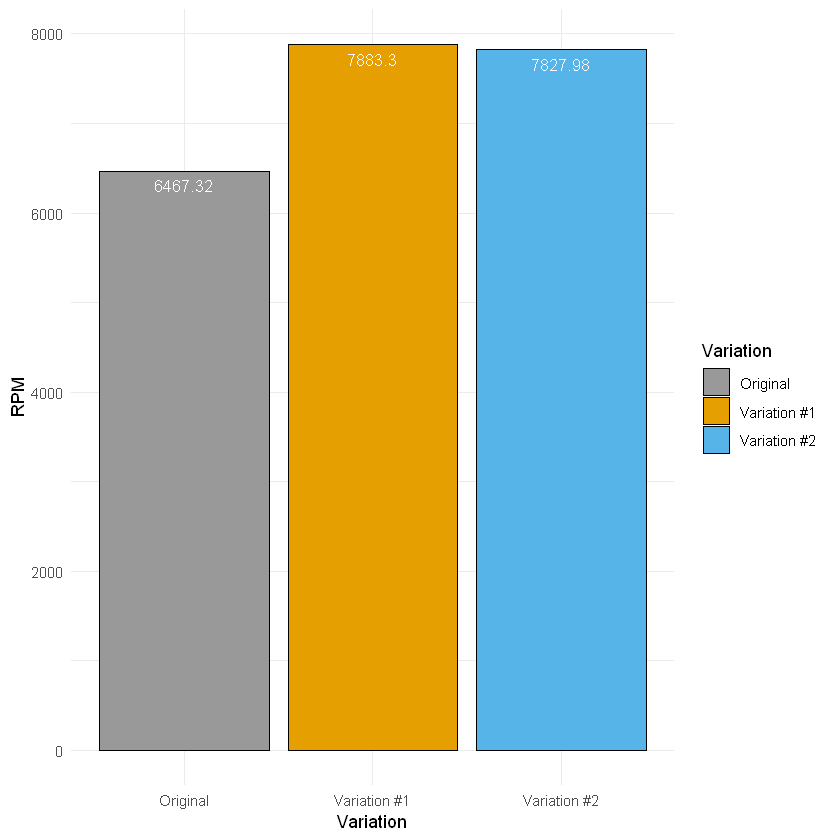

In [13]:
chart4

# CTR

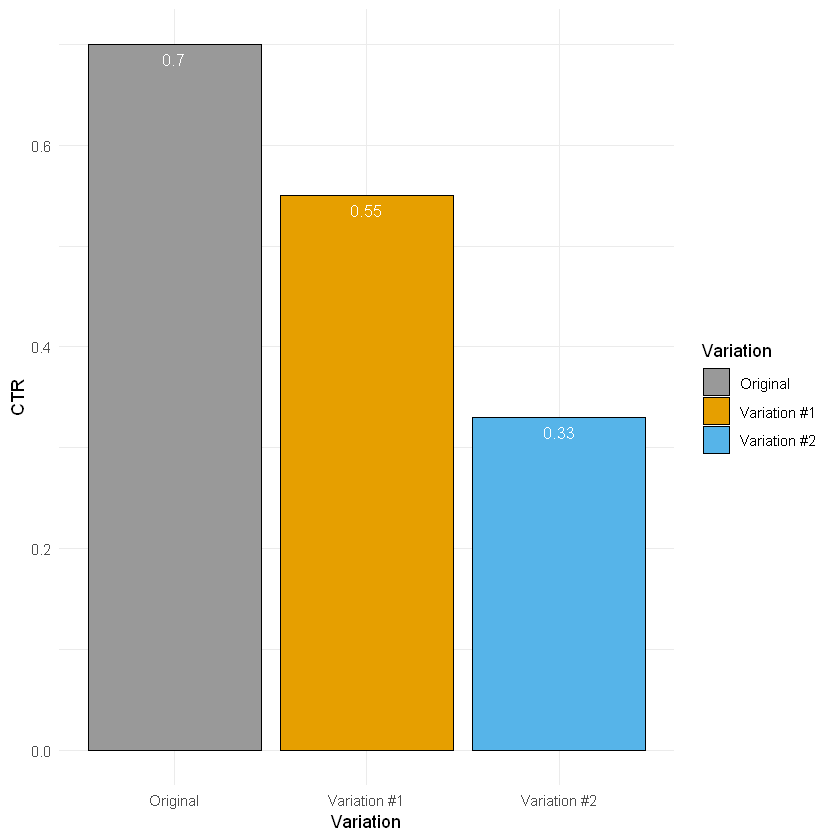

In [14]:
chart5

# Numero de Llamadas

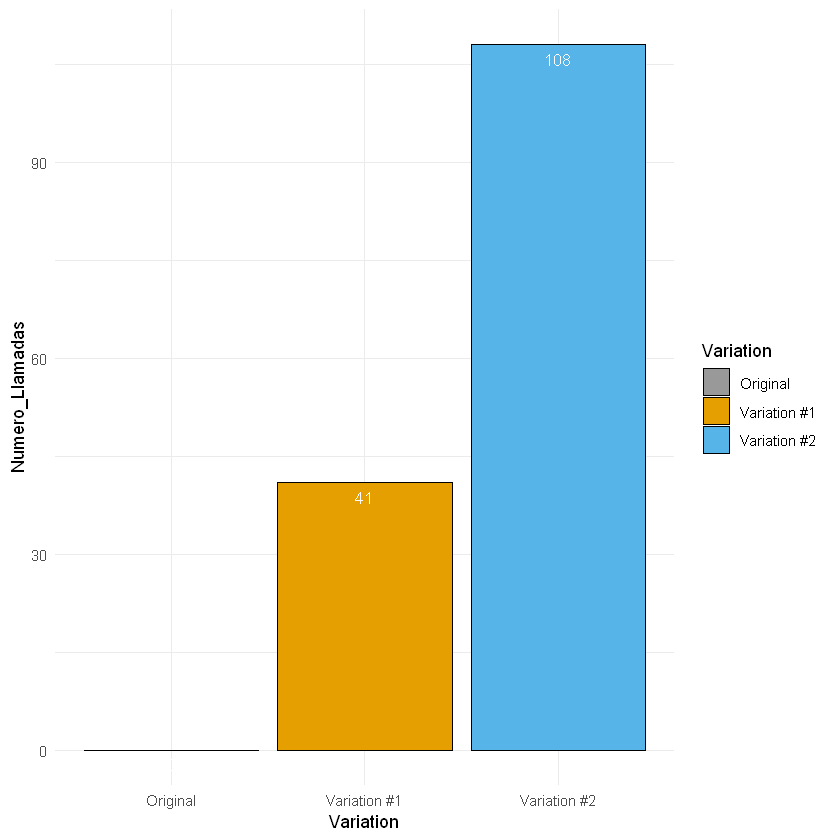

In [15]:
chart6

# Resumen

In [16]:
df3

Variation,Revenue_TYP,RPM,CTR,Numero_Llamadas
Original,698.4701,6467.32,0.70,0
Variation #1,1679.1431,7883.30,0.55,41
Variation #2,3452.1398,7827.98,0.33,108
